In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from google.colab import drive
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
# Mount google drive to colab notebook
drive.mount('/content/drive', force_remount=True)

# Specify dataset location in mounted drive
DATA = '/content/drive/MyDrive/ML_project_two/ML_patent_data_filtered/final_dataset/features/features.csv'

# Specify word2vec datasets locations
WORD2VEC_ROOT = '/content/drive/MyDrive/ML_project_two/word_vector/'
INDEX = WORD2VEC_ROOT + 'index.txt'
WORD2VEC_FLOAT = WORD2VEC_ROOT + 'float/word_vector_NUMBER_float.csv'

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


### Helper Functions

In [ ]:
def compute_metrics(y_pred, y_test):
    # Round float predictions to the respective classes
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
  
    # Compute true/false positives/negatives
    tp = torch.logical_and(y_pred_tag == 1, y_test == 1).sum()
    fp = torch.logical_and(y_pred_tag == 1, y_test == 0).sum()
    tn = torch.logical_and(y_pred_tag == 0, y_test == 0).sum()
    fn = torch.logical_and(y_pred_tag == 0, y_test == 1).sum()

    # Compute accuracy, precision, recall and f1 score
    acc = ((tp + tn) / (tp + tn + fp + fn))
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * (prec * rec) / (prec + rec)
    return acc, prec, rec, f1

### Data Classes

In [ ]:
class PatentDataset(Dataset):
    def __init__(self):

        print("Loading attorney and inventor data...")
        # Load csv file
        df = pd.read_csv(DATA, delimiter=',', 
                              usecols=['application_number',
                                       'approved',
                                       'examiner_art_unit',
                                       'inventors_number',
                                       'inventors_avg_toal_patents',
                                       'attorneys_number',
                                       'attorneys_avg_total_patents'])

        # # Initialize a dataframe to contain word2vec information, which will later
        # # be merged with the attorney/inventor dataframe 
        # w2v_df = pd.DataFrame()

        # # There are 43 files containing w2v data
        # # Only load some to save memory
        # w2v_idx_subset = np.random.default_rng(seed=1).choice(43, size=5, replace=False)
        # for i in w2v_idx_subset:
        #     # Build file name and load csv
        #     w2v_filename = WORD2VEC_FLOAT.replace('NUMBER', str(i))

        #     # Read csv and append to general w2v dataframe
        #     print(f"Loading {w2v_filename}...")
        #     w2v_sub_df = pd.read_csv(w2v_filename)
        #     w2v_df = w2v_df.append(w2v_sub_df)

        # # Perform an inner join between the word2vec dataset and the attorney/
        # # inventors features dataset.
        # df = df.merge(w2v_df, how='inner', on='application_number')
        
        # Drop application_number feature
        df = df.drop(labels='application_number', axis=1)
        
        # One-hot encode the art unit feature
        df = pd.get_dummies(df, columns=['examiner_art_unit'])

        # Convert the pandas dataframe into a numpy 2d matrix for performance
        dataset = df.to_numpy(dtype='float32')

        # Set length
        self.len = dataset.shape[0]

        # Set features and labels
        self.x = dataset[:, 1:]
        self.y = dataset[:, 0][:, None]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

### Net Classes

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [ ]:
class DeeperBinaryClassifier(nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super(DeeperBinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, H)
        self.linear3 = nn.Linear(H, H)
        self.linear4 = nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        h_relu3 = self.linear3(h_relu2).clamp(min=0)
        y_pred = self.linear4(h_relu3)
        return y_pred

## Testing

### Data pre-process

In [ ]:
TRAIN_SPLIT = 0.8
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1024

In [ ]:
dataset = PatentDataset()

Loading attorney and inventor data...


In [ ]:
dataset.y.sum(dtype='int') / dataset.y.shape[0]

0.5402285944985864

In [ ]:
# Data pre-processing
# Split data in training and test set
train_size = int(len(dataset) * TRAIN_SPLIT)
trainset, testset = random_split(dataset, [train_size, len(dataset)-train_size])

# Initialize DataLoaders
train_loader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

### Net creation and training

In [ ]:
dataset.x.shape[1]

667

In [ ]:
# Create the net
net = BinaryClassifier(D_in=dataset.x.shape[1], H=1000)
net.to(device)

# Select loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Create lists to track performance metrics
batch_loss = []
batch_accuracy = []
batch_precision = []
batch_recall = []
batch_f1 = []

# Set number of epochs
epochs = 1

# Set net mode to training
net.train()

# Train
for epoch in range(epochs):
    for x_batch, y_batch in tqdm(train_loader):
        # Move data to GPU if available
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Reset tensor gradients from prev batch
        optimizer.zero_grad()

        # Forward pass
        y_pred = net(x_batch)

        # Compute metrics
        loss = loss_fn(y_pred, y_batch)
        acc, prec, rec, f1 = compute_metrics(y_pred, y_batch)
        batch_loss.append(loss.item())
        batch_accuracy.append(acc.item())
        batch_precision.append(prec.item())
        batch_recall.append(prec.item())
        batch_f1.append(f1.item())

        # Backward pass
        loss.backward()
        optimizer.step()

100%|██████████| 10466/10466 [01:19<00:00, 131.40it/s]


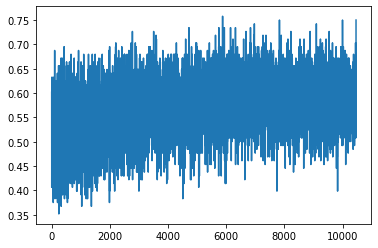

In [ ]:
plt.plot(batch_accuracy)

In [ ]:
np.asarray(batch_accuracy)[8000:].mean()

0.5857727595296026

In [ ]:
# Set net mode to evaluation
net.eval()

# Create list to track accuracy
test_acc = []

for x_batch, y_batch in tqdm(test_loader):
    # Move data to GPU if available
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # Calculate prediction
    y_pred = net(x_batch)
    # Calculate accuracy
    test_acc.append(binary_acc(y_pred, y_batch).item())

100%|██████████| 328/328 [00:04<00:00, 73.85it/s]


In [ ]:
np_test_acc = np.asarray(test_acc)
np_test_acc.mean()

55.2916692291818